# Clustering summaries

In [2]:
import pandas as pd
from collections import defaultdict
import numpy as np

In [3]:
df = pd.read_csv('data/ilpd-clustered.csv')

In [4]:
clustering_columns = [col for col in df.columns if 'cluster' in col.lower()]

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_columns = [col for col in numerical_columns if col not in clustering_columns]

continuous_feature_columns = [col for col in feature_columns if col != 'Label']

In [5]:
# Calculate gender proportions for each clustering method
gender_stats = {}

for cluster_col in clustering_columns:
    unique_clusters = sorted(df[cluster_col].unique())
    
    gender_stats[cluster_col] = {}
    
    for cluster in unique_clusters:
        cluster_data = df[df[cluster_col] == cluster]
        gender_counts = cluster_data['Gender'].value_counts()
        total_count = len(cluster_data)
        
        gender_proportions = gender_counts / total_count
        
        gender_stats[cluster_col][f'cluster_{cluster}'] = {
            'total_count': total_count,
            'gender_counts': gender_counts.to_dict(),
            'gender_proportions': gender_proportions.to_dict()
        }

In [6]:
# Create comprehensive summary DataFrames including gender
comprehensive_summary = []

for cluster_method in clustering_columns:
    unique_clusters = sorted(df[cluster_method].unique())
    
    for cluster in unique_clusters:
        cluster_id = str(cluster)
        
        cluster_data = df[df[cluster_method] == cluster][feature_columns]
        means = cluster_data.mean()
        medians = cluster_data.median()
        stds = cluster_data.std()
        
        gender_info = gender_stats[cluster_method][f'cluster_{cluster}']
        
        base_row = {
            'Clustering_Method': cluster_method,
            'Cluster': cluster_id,
            'Sample_Count': gender_info['total_count']
        }
        
        for feature in feature_columns:
            base_row[f'{feature}_Mean'] = means[feature]
            base_row[f'{feature}_Median'] = medians[feature]
            base_row[f'{feature}_Std'] = stds[feature]
        
        for gender, proportion in gender_info['gender_proportions'].items():
            base_row[f'Gender_{gender}_Proportion'] = proportion
            base_row[f'Gender_{gender}_Count'] = gender_info['gender_counts'][gender]
        
        comprehensive_summary.append(base_row)

comprehensive_df = pd.DataFrame(comprehensive_summary)

In [7]:
comprehensive_df.to_csv('data/ilpd-clustering_summary.csv', index=False)

# CLUSTER COMPARISON

## Spectral Clustering

In [8]:
comprehensive_df = pd.read_csv('data/ilpd-clustering_summary.csv')

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

spectral_methods = [col for col in clustering_columns if 'spectral' in col.lower()]
spectral_data = comprehensive_df[comprehensive_df['Clustering_Method'].isin(spectral_methods)].copy()

spectral_data['k_value'] = spectral_data['Clustering_Method'].str.extract(r'k(\d+)').astype(int)
spectral_data = spectral_data.sort_values(['k_value', 'Cluster'])

# Get feature columns
print(f"Spectral clustering methods found: {spectral_methods}")
print(f"K values available: {sorted(spectral_data['k_value'].unique())}")

Spectral clustering methods found: ['Clusters_Spectral_k2', 'Clusters_Spectral_k4', 'Clusters_Spectral_k6']
K values available: [np.int64(2), np.int64(4), np.int64(6)]


## Sample Count per Cluster

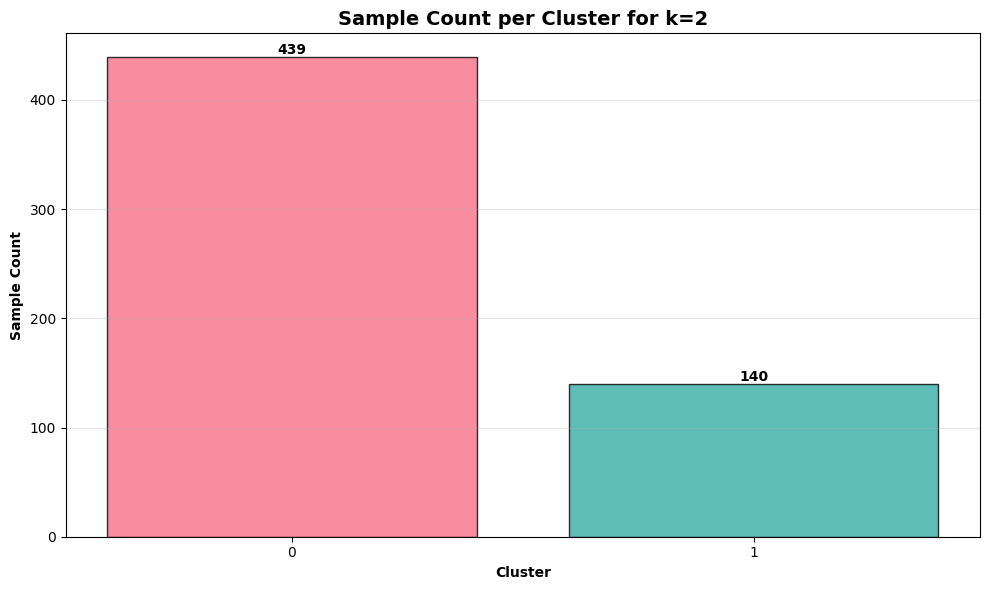

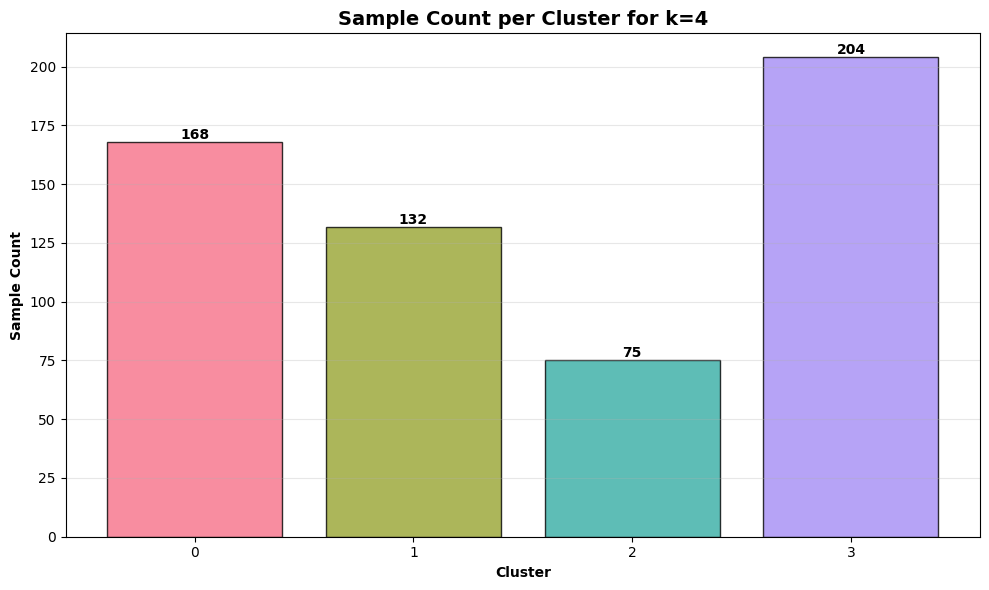

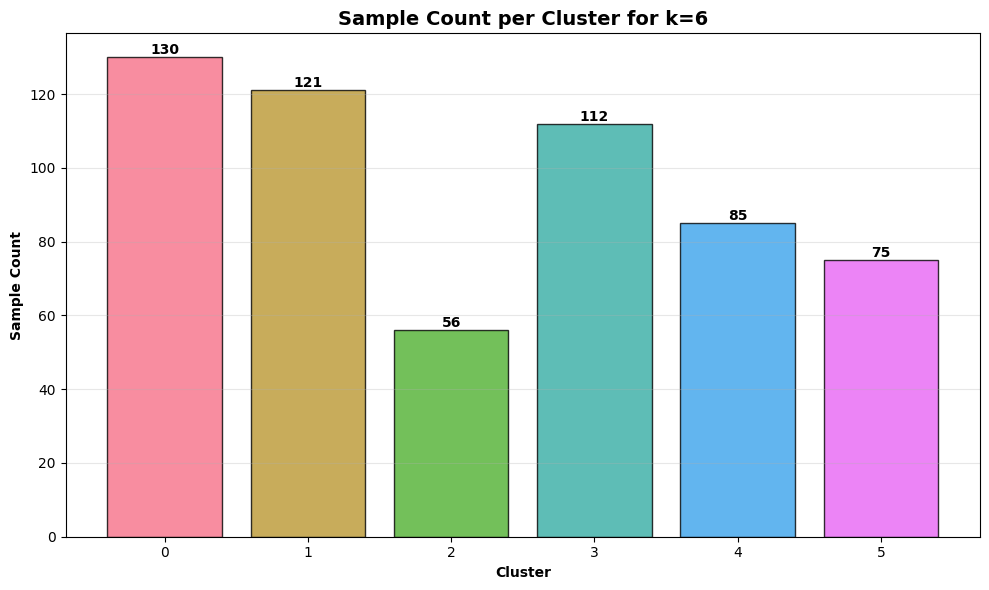

In [10]:
def plot_sample_count_by_k(k_value):
    k_data = spectral_data[spectral_data['k_value'] == k_value].copy()
    k_data = k_data.sort_values('Cluster')
    
    plt.figure(figsize=(10, 6))
    
    clusters = k_data['Cluster'].astype(str)
    sample_counts = k_data['Sample_Count']
    
    colors = sns.color_palette("husl", len(clusters))
    
    bars = plt.bar(clusters, sample_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
    plt.title(f'Sample Count per Cluster for k={k_value}', fontweight='bold', fontsize=14)
    plt.xlabel('Cluster', fontweight='bold')
    plt.ylabel('Sample Count', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()

k_values = sorted(spectral_data['k_value'].unique())
for k in k_values:
    plot_sample_count_by_k(k)

## Feature Boxplots

In [11]:
def plot_feature_boxplots(cluster_col):
    n_features = len(continuous_feature_columns)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    for i, feature in enumerate(continuous_feature_columns):
        ax = axes[i]
        sns.boxplot(x=cluster_col, y=feature, data=df, ax=ax, palette='husl')
        ax.set_title(f'Boxplot of {feature} by Cluster', fontweight='bold', fontsize=12)
        ax.set_xlabel('Cluster', fontweight='bold')
        ax.set_ylabel(feature, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
    
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'Feature Boxplots for {cluster_col}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

### Clusters_Spectral_k4

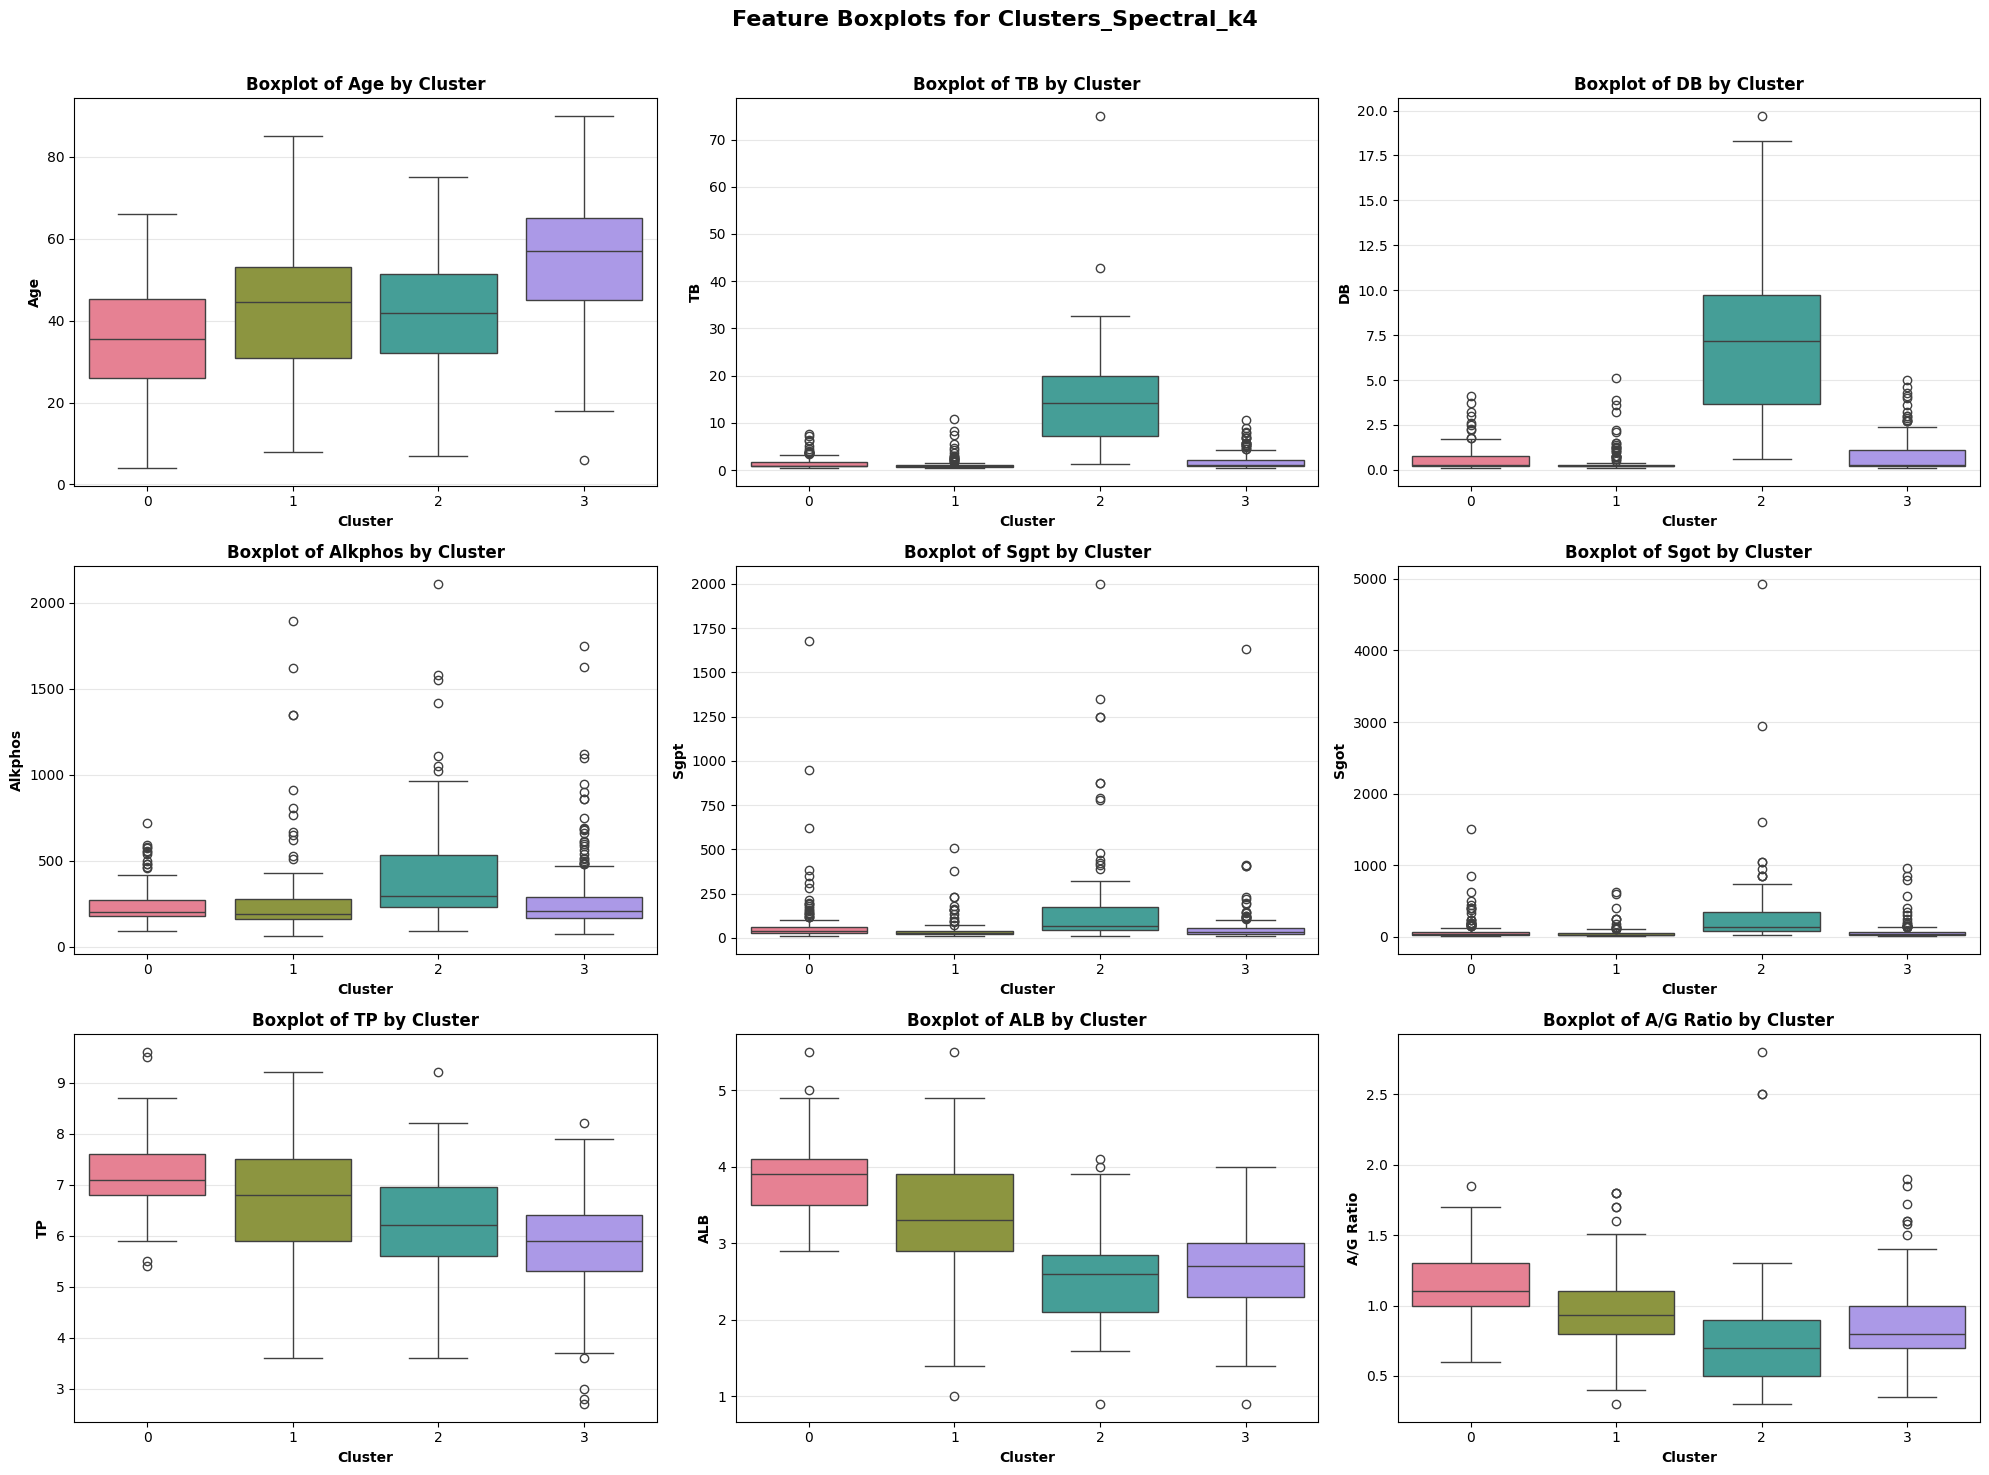

In [12]:
plot_feature_boxplots('Clusters_Spectral_k4')

### Boxplot for Feature Distribution across Clusters in Spectral k=6

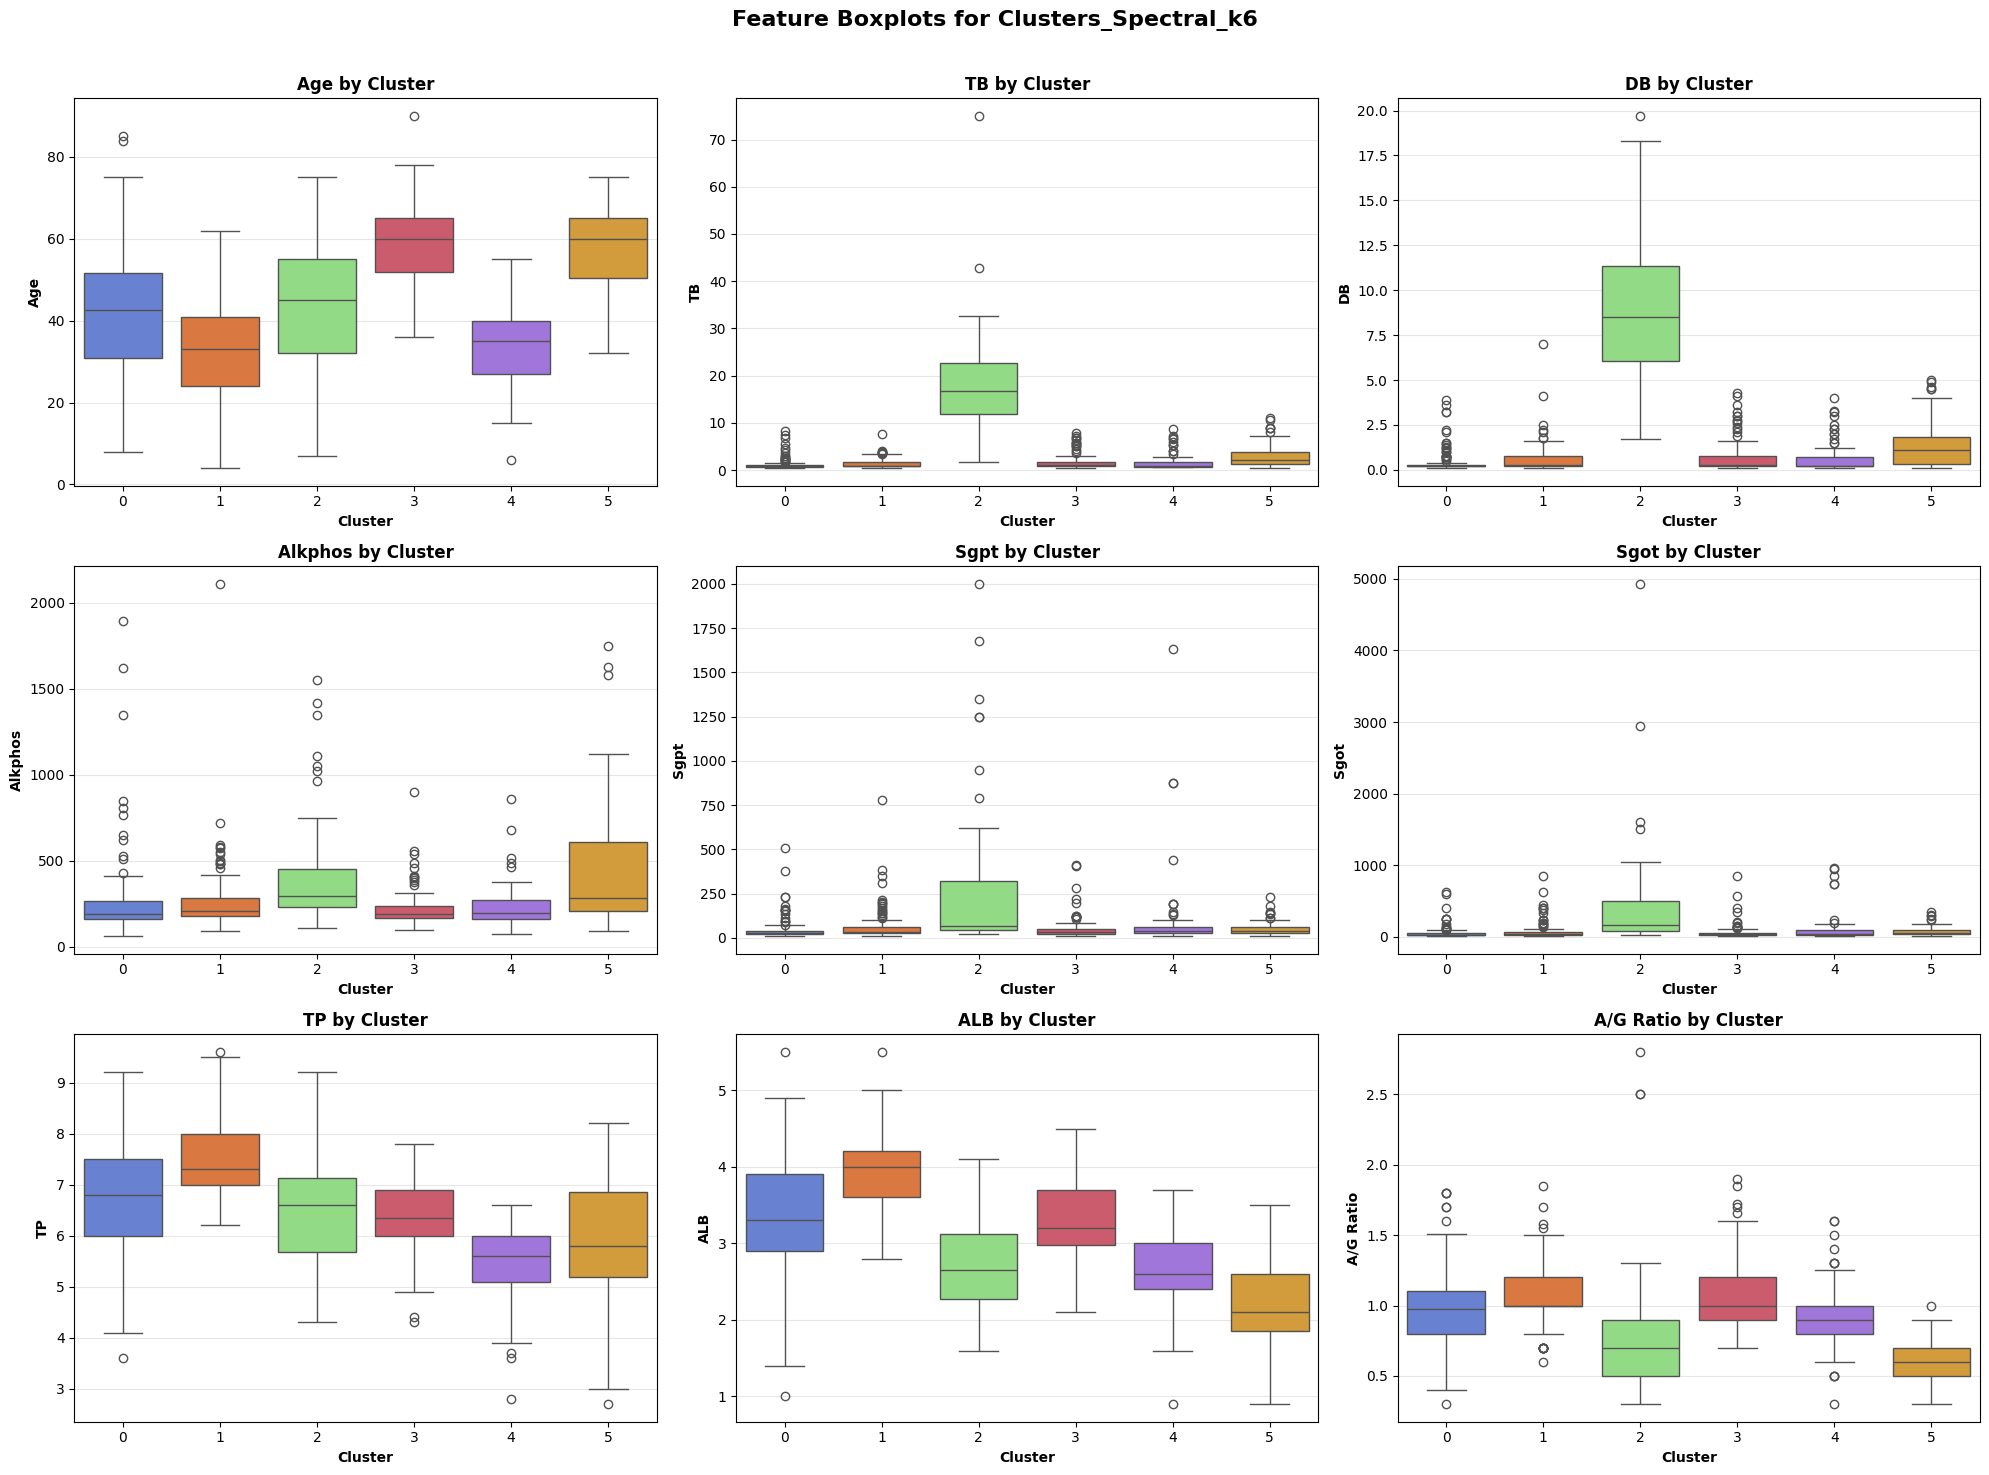

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

clustering_columns = [col for col in df.columns if 'cluster' in col.lower()]

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_columns = [col for col in numerical_columns if col not in clustering_columns]

continuous_feature_columns = [col for col in feature_columns if col != 'Label']

def plot_feature_boxplots_by_cluster(df, cluster_col):

    n_features = len(continuous_feature_columns)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()

    manual_colors = ["#5679e3", "#f27127", "#89e879", "#de4962", "#9f65eb", "#eba123"]

    df_plot = df.copy()
    df_plot[cluster_col] = df_plot[cluster_col].astype(str)

    unique_clusters = sorted(df_plot[cluster_col].unique(), key=int)

    palette = {c: manual_colors[int(c) % len(manual_colors)] for c in unique_clusters}

    # Plot
    for i, feature in enumerate(continuous_feature_columns):
        ax = axes[i]
        sns.boxplot(
            x=cluster_col,
            y=feature,
            data=df_plot,
            ax=ax,
            palette=palette,
            order=unique_clusters
        )
        ax.set_title(f'{feature} by Cluster', fontweight='bold', fontsize=12)
        ax.set_xlabel('Cluster', fontweight='bold')
        ax.set_ylabel(feature, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')


    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(f'Feature Boxplots for {cluster_col}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_feature_boxplots_by_cluster(df, "Clusters_Spectral_k6")


## Distribution of Liver Disease Diagnosis

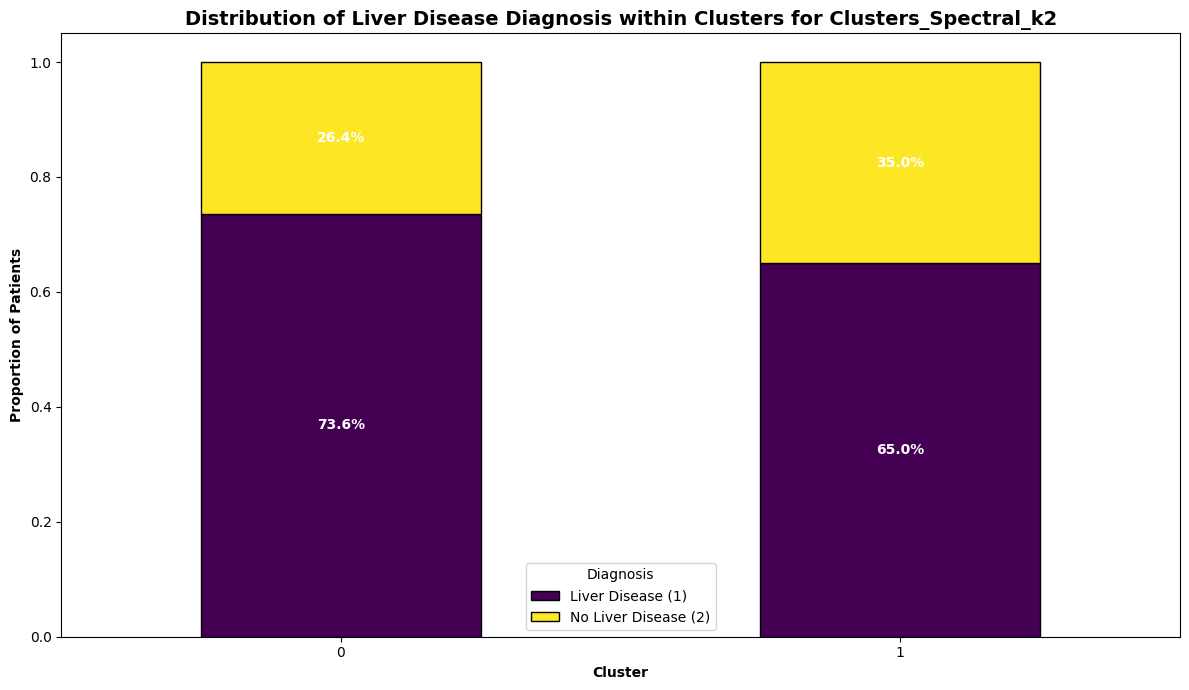

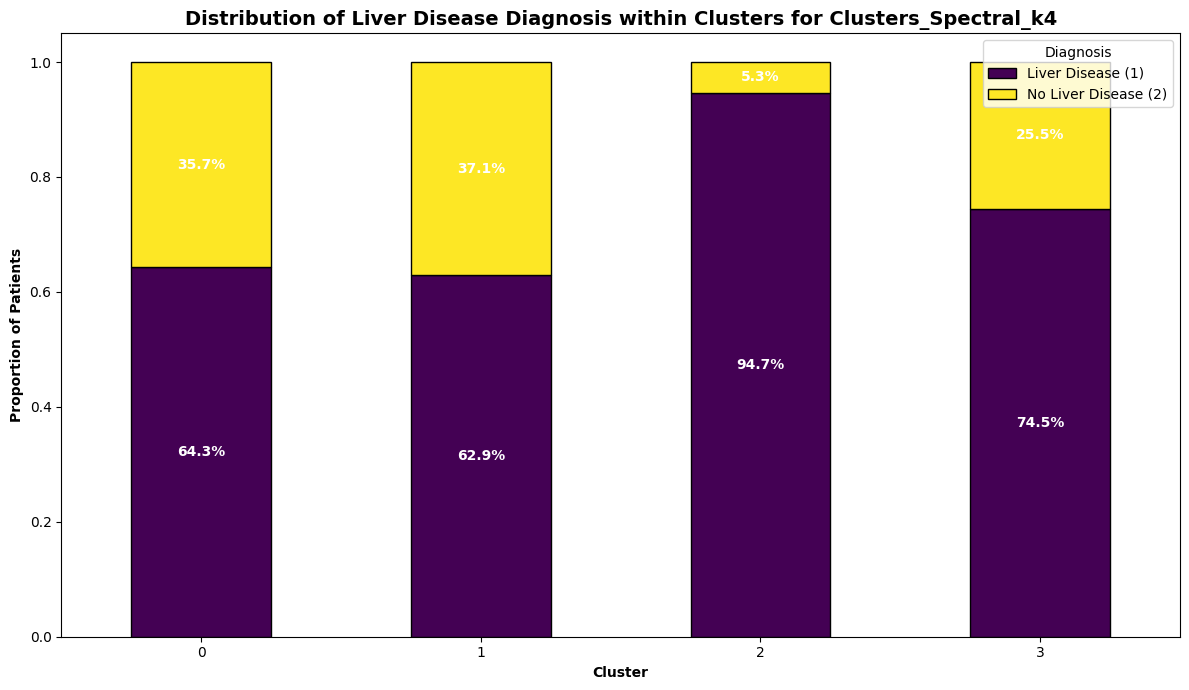

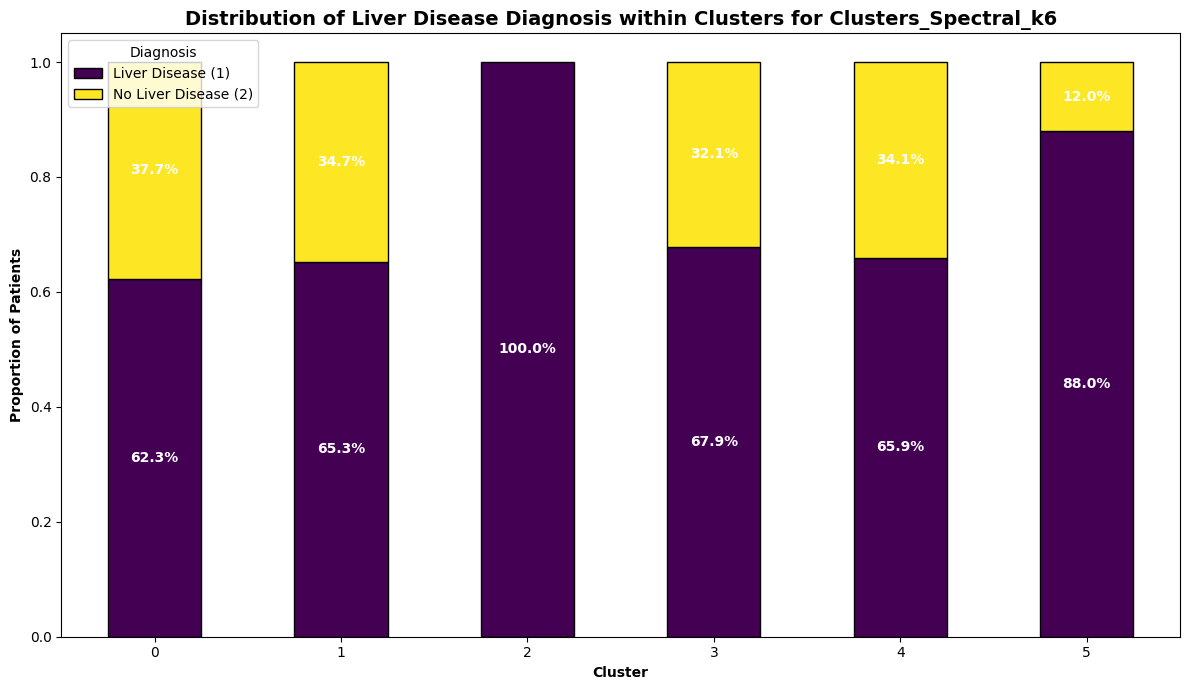

In [15]:
def plot_label_distribution(cluster_col):
    label_counts = df.groupby([cluster_col, 'Label']).size().unstack(fill_value=0)
    
    label_proportions = label_counts.divide(label_counts.sum(axis=1), axis=0)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    if 1 not in label_proportions.columns:
        label_proportions[1] = 0
    if 2 not in label_proportions.columns:
        label_proportions[2] = 0
    label_proportions = label_proportions[[1, 2]]


    label_proportions.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', edgecolor='black')
    
    ax.set_title(f'Distribution of Liver Disease Diagnosis within Clusters for {cluster_col}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cluster', fontweight='bold')
    ax.set_ylabel('Proportion of Patients', fontweight='bold')
    ax.legend(title='Diagnosis', labels=['Liver Disease (1)', 'No Liver Disease (2)'])
    ax.tick_params(axis='x', rotation=0)
    
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 0.01:
            x, y = p.get_xy()
            ax.text(x + width / 2, 
                    y + height / 2, 
                    f'{height:.1%}', 
                    ha='center', 
                    va='center',
                    color='white',
                    fontweight='bold',
                    fontsize=10)

    plt.tight_layout()
    plt.show()

for method in spectral_methods:
    plot_label_distribution(method)

## Gender Distribution

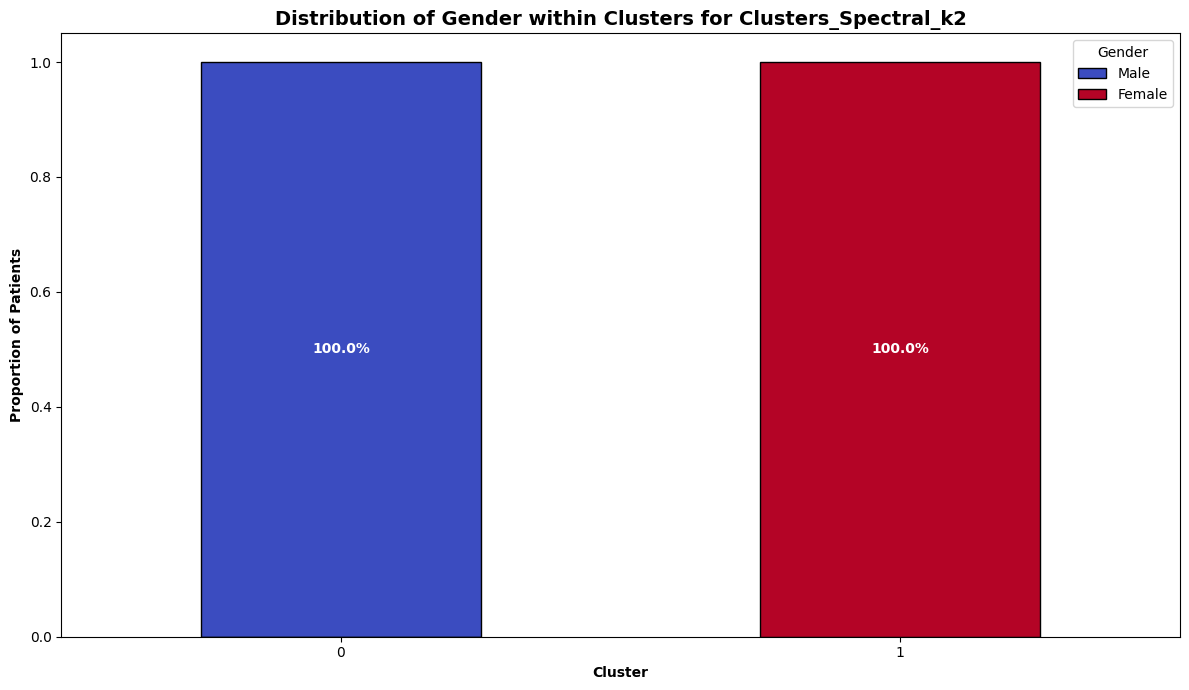

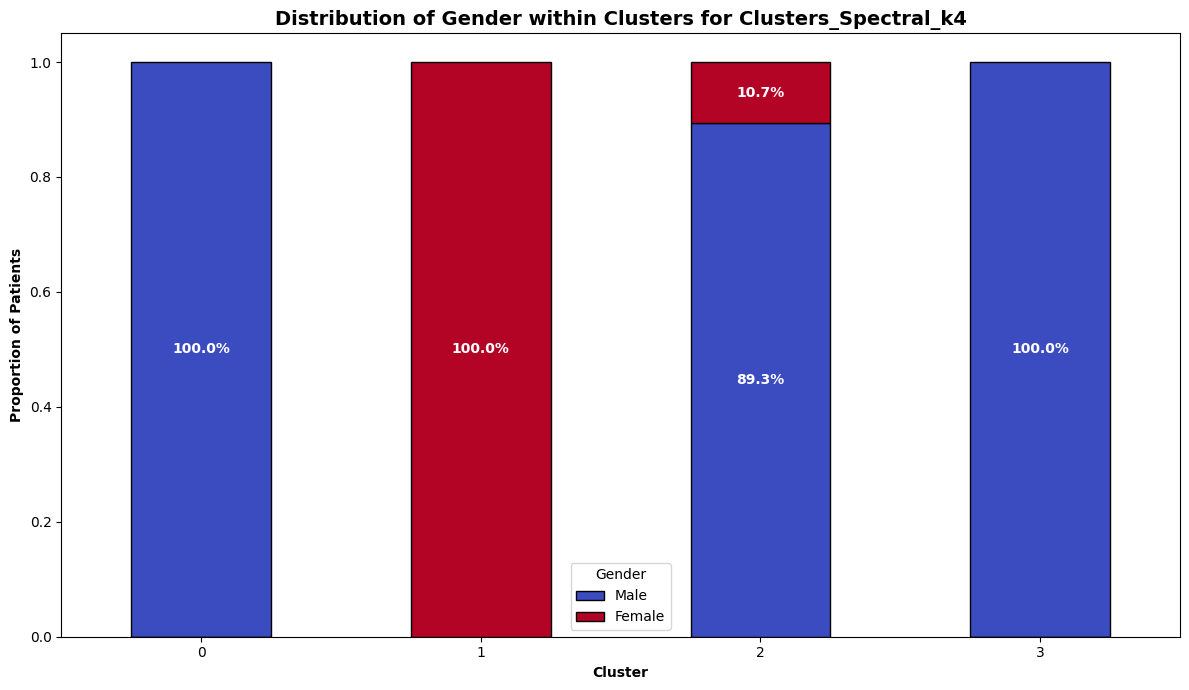

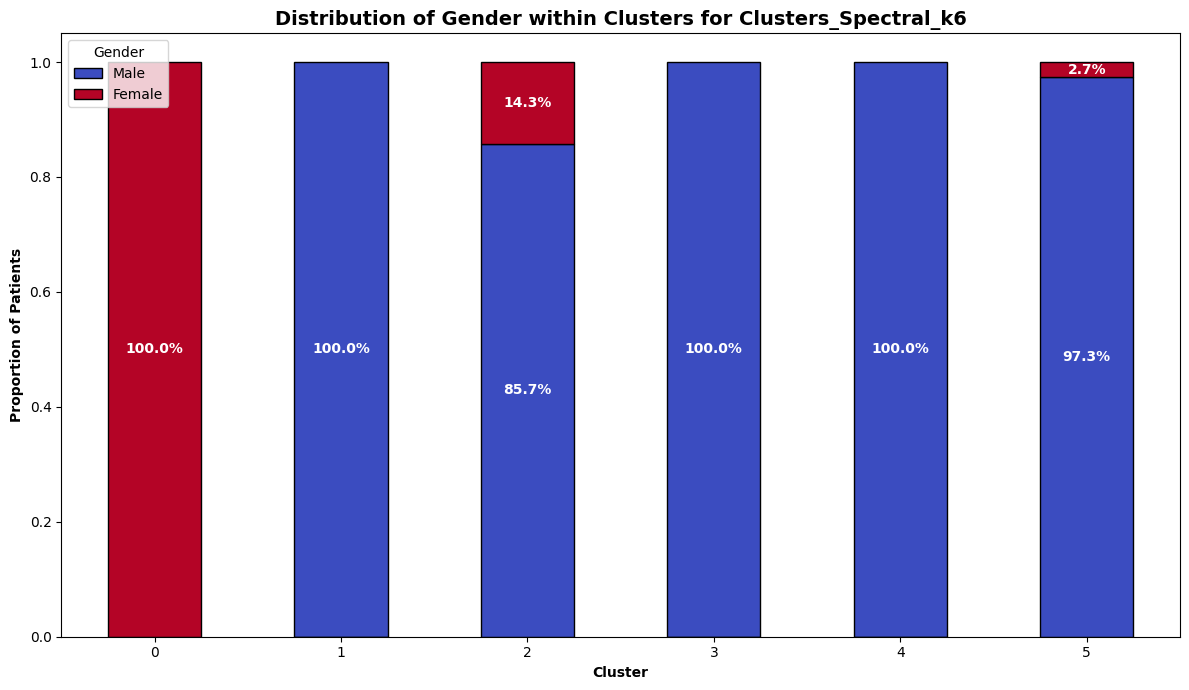

In [16]:
def plot_gender_distribution(cluster_col):
    gender_counts = df.groupby([cluster_col, 'Gender']).size().unstack(fill_value=0)
    
    gender_proportions = gender_counts.divide(gender_counts.sum(axis=1), axis=0)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    if 'Male' not in gender_proportions.columns:
        gender_proportions['Male'] = 0
    if 'Female' not in gender_proportions.columns:
        gender_proportions['Female'] = 0
    gender_proportions = gender_proportions[['Male', 'Female']]
    
    gender_proportions.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm', edgecolor='black')
    
    ax.set_title(f'Distribution of Gender within Clusters for {cluster_col}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cluster', fontweight='bold')
    ax.set_ylabel('Proportion of Patients', fontweight='bold')
    ax.legend(title='Gender')
    ax.tick_params(axis='x', rotation=0)
    
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 0.01:
            x, y = p.get_xy()
            ax.text(x + width / 2, 
                    y + height / 2, 
                    f'{height:.1%}', 
                    ha='center', 
                    va='center',
                    color='white',
                    fontweight='bold',
                    fontsize=10)

    plt.tight_layout()
    plt.show()

for method in spectral_methods:
    plot_gender_distribution(method)

## Statistical Tests for Continuous Variables

In [17]:
from scipy.stats import f_oneway, shapiro, kruskal, chi2_contingency, chisquare

### Automated Statistical Testing (ANOVA vs. Kruskal-Wallis)

In [18]:
def perform_appropriate_test(cluster_col, feature, alpha=0.05):
    unique_clusters = sorted(df[cluster_col].unique())
    
    is_normal = True
    cluster_groups = []
    for cluster in unique_clusters:
        cluster_data = df[df[cluster_col] == cluster][feature]
        cluster_groups.append(cluster_data)
        
        if len(cluster_data) >= 3:
            stat, p_value = shapiro(cluster_data)
            if p_value < alpha:
                is_normal = False
        else:
            is_normal = False

    if is_normal:
        # All groups are normal, so use ANOVA
        f_stat, p_value = f_oneway(*cluster_groups)
        test_used = 'ANOVA'
        statistic_name = 'F-statistic'
        statistic_value = f_stat
    else:
        # At least one group is not normal, so use Kruskal-Wallis
        h_stat, p_value = kruskal(*cluster_groups)
        test_used = 'Kruskal-Wallis'
        statistic_name = 'H-statistic'
        statistic_value = h_stat
        
    return {
        'Feature': feature,
        'Test Used': test_used,
        statistic_name: statistic_value,
        'P-value': p_value,
        'Significant': 'Yes' if p_value < alpha else 'No'
    }

# --- Perform and Display Automated Test Results ---
for method in spectral_methods:
    print(f"--- Automated Statistical Test Results for {method} ---")
    
    results = []
    for feature in continuous_feature_columns:
        test_result = perform_appropriate_test(method, feature)
        results.append(test_result)
    
    results_df = pd.DataFrame(results)
    print(results_df)
    print("\n")

--- Automated Statistical Test Results for Clusters_Spectral_k2 ---
     Feature       Test Used  H-statistic       P-value Significant
0        Age  Kruskal-Wallis     2.176927  1.400940e-01          No
1         TB  Kruskal-Wallis    22.417552  2.193601e-06         Yes
2         DB  Kruskal-Wallis    25.099594  5.444431e-07         Yes
3    Alkphos  Kruskal-Wallis     3.434516  6.384729e-02          No
4       Sgpt  Kruskal-Wallis    22.322324  2.305113e-06         Yes
5       Sgot  Kruskal-Wallis    24.209678  8.639706e-07         Yes
6         TP  Kruskal-Wallis     5.464863  1.940257e-02         Yes
7        ALB  Kruskal-Wallis     5.440218  1.967821e-02         Yes
8  A/G Ratio  Kruskal-Wallis     0.044214  8.334566e-01          No


--- Automated Statistical Test Results for Clusters_Spectral_k4 ---
     Feature       Test Used  H-statistic       P-value Significant
0        Age  Kruskal-Wallis   128.967101  9.029392e-28         Yes
1         TB  Kruskal-Wallis   188.213649  1.4

## Chi-Square Test for Categorical Variables

In [19]:
def perform_chi_square_test(cluster_col, feature, alpha=0.05):
    contingency_table = pd.crosstab(df[cluster_col], df[feature])
    
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    return {
        'Feature': feature,
        'Chi2-statistic': chi2_stat,
        'P-value': p_value,
        'Significant': 'Yes' if p_value < alpha else 'No'
    }

# --- Perform and Display Chi-Square Test Results ---
categorical_features_to_test = ['Gender', 'Label']

for method in spectral_methods:
    print(f"--- Chi-Square Test Results for {method} ---")
    
    results = []
    for feature in categorical_features_to_test:
        test_result = perform_chi_square_test(method, feature)
        results.append(test_result)
    
    results_df = pd.DataFrame(results)
    print(results_df)
    print("\n")

--- Chi-Square Test Results for Clusters_Spectral_k2 ---
  Feature  Chi2-statistic        P-value Significant
0  Gender      573.558226  9.447374e-127         Yes
1   Label        3.422331   6.432014e-02          No


--- Chi-Square Test Results for Clusters_Spectral_k4 ---
  Feature  Chi2-statistic        P-value Significant
0  Gender      540.017643  1.012989e-116         Yes
1   Label       29.767179   1.544774e-06         Yes


--- Chi-Square Test Results for Clusters_Spectral_k6 ---
  Feature  Chi2-statistic        P-value Significant
0  Gender      530.978557  1.638163e-112         Yes
1   Label       42.071072   5.698527e-08         Yes




### Chi-Square Goodness-of-Fit Test (Cluster vs. Total)

In [20]:
def perform_goodness_of_fit_test(cluster_col, cluster_id, feature, alpha=0.05):
    """
    Performs a Chi-Square Goodness-of-Fit test to see if the distribution
    of a categorical feature within a specific cluster differs from the overall distribution.
    """
    # 1. Calculate the overall distribution of the feature in the entire dataset
    total_distribution = df[feature].value_counts(normalize=True)
    
    # 2. Get the observed counts of the feature in the specified cluster
    cluster_data = df[df[cluster_col] == cluster_id]
    observed_counts = cluster_data[feature].value_counts()
    
    # Ensure all categories from the total distribution are present in the observed counts
    observed_counts = observed_counts.reindex(total_distribution.index, fill_value=0)
    
    # 3. Calculate the expected counts for the cluster based on the total distribution
    total_in_cluster = len(cluster_data)
    expected_counts = total_distribution * total_in_cluster
    
    # The chisquare test requires that expected counts are not zero.
    # We will filter out categories with zero expected counts.
    non_zero_mask = expected_counts > 0
    observed_counts = observed_counts[non_zero_mask]
    expected_counts = expected_counts[non_zero_mask]

    if len(observed_counts) < 2:
        return {
            'Feature': feature,
            'Chi2-statistic': 'N/A',
            'P-value': 'N/A',
            'Significant': 'Not enough data'
        }

    # 4. Perform the Chi-Square Goodness-of-Fit test
    chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)
    
    return {
        'Feature': feature,
        'Chi2-statistic': chi2_stat,
        'P-value': p_value,
        'Significant': 'Yes' if p_value < alpha else 'No'
    }

# --- Perform and Display Goodness-of-Fit Test Results ---
categorical_features_to_test = ['Label']

for method in spectral_methods:
    print(f"--- Goodness-of-Fit Test Results for {method} ---")
    
    unique_clusters = sorted(df[method].unique())
    
    for cluster_id in unique_clusters:
        print(f"  - Cluster {cluster_id} vs. Total Population:")
        
        results = []
        for feature in categorical_features_to_test:
            test_result = perform_goodness_of_fit_test(method, cluster_id, feature)
            results.append(test_result)
        
        results_df = pd.DataFrame(results)
        print(results_df)
        print("\n")

--- Goodness-of-Fit Test Results for Clusters_Spectral_k2 ---
  - Cluster 0 vs. Total Population:
  Feature  Chi2-statistic   P-value Significant
0   Label        0.926483  0.335779          No


  - Cluster 1 vs. Total Population:
  Feature  Chi2-statistic   P-value Significant
0   Label        2.905184  0.088295          No


--- Goodness-of-Fit Test Results for Clusters_Spectral_k4 ---
  - Cluster 0 vs. Total Population:
  Feature  Chi2-statistic   P-value Significant
0   Label        4.294184  0.038243         Yes


  - Cluster 1 vs. Total Population:
  Feature  Chi2-statistic   P-value Significant
0   Label        4.817752  0.028168         Yes


  - Cluster 2 vs. Total Population:
  Feature  Chi2-statistic   P-value Significant
0   Label       19.749862  0.000009         Yes


  - Cluster 3 vs. Total Population:
  Feature  Chi2-statistic   P-value Significant
0   Label        0.905381  0.341343          No


--- Goodness-of-Fit Test Results for Clusters_Spectral_k6 ---
  - Cluste

In [21]:
from scipy.stats import chi2_contingency

# Test: Are clusters and disease labels independent?
contingency_table = pd.crosstab(df['Clusters_Spectral_k4'], df['Label'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test (Independence):")
print(f"Chi2 = {chi2:.3f}, p-value = {p_value}")
print(f"Degrees of freedom = {dof}")

if p_value < 0.05:
    print("✓ Clusters and disease status are DEPENDENT (clusters found real disease patterns)")
else:
    print("✗ Clusters and disease are INDEPENDENT (clustering didn't work)")

Chi-Square Test (Independence):
Chi2 = 29.767, p-value = 1.5447739221105478e-06
Degrees of freedom = 3
✓ Clusters and disease status are DEPENDENT (clusters found real disease patterns)


In [5]:
import pandas as pd
import plotly.graph_objects as go

# Load the dataset
df = pd.read_csv('data/ilpd-clustered.csv')

# --- Data Preparation for Sankey Plot ---
cluster_cols = ['Clusters_Spectral_k2', 'Clusters_Spectral_k4', 'Clusters_Spectral_k6']

# Create labels for the nodes
labels = []
for col in cluster_cols:
    k_val = col.split('_k')[-1]
    labels.extend([f'k{k_val}_c{i}' for i in sorted(df[col].unique())])

label_to_id = {label: i for i, label in enumerate(labels)}

# --- Create Links ---
links_k2_k4 = df.groupby([cluster_cols[0], cluster_cols[1]]).size().reset_index(name='value')
links_k2_k4['source'] = links_k2_k4[cluster_cols[0]].apply(lambda x: label_to_id[f'k2_c{x}'])
links_k2_k4['target'] = links_k2_k4[cluster_cols[1]].apply(lambda x: label_to_id[f'k4_c{x}'])

links_k4_k6 = df.groupby([cluster_cols[1], cluster_cols[2]]).size().reset_index(name='value')
links_k4_k6['source'] = links_k4_k6[cluster_cols[1]].apply(lambda x: label_to_id[f'k4_c{x}'])
links_k4_k6['target'] = links_k4_k6[cluster_cols[2]].apply(lambda x: label_to_id[f'k6_c{x}'])

all_links = pd.concat([links_k2_k4, links_k4_k6], axis=0)

# --- Assign Colors ---

# Palette for each k-value
colors_k2 = ['#4B8BBE', '#306998']      # blu
colors_k4 = ['#FFD43B', '#FFE873', '#FFB347', '#FF8C00']  # giallo-arancio
colors_k6 = ['#8BC34A', '#66BB6A', '#4CAF50', '#388E3C', '#2E7D32', '#1B5E20']  # verde

node_colors = colors_k2 + colors_k4 + colors_k6

# Function to convert HEX to RGBA with transparency
def hex_to_rgba(hex_color, alpha=0.3):
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgba({r},{g},{b},{alpha})'

# Create link colors based on source node
link_colors = [hex_to_rgba(node_colors[s], 0.3) for s in all_links['source']]

# --- Create the Sankey Plot ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=all_links['source'],
        target=all_links['target'],
        value=all_links['value'],
        color=link_colors
    ))])

fig.update_layout(
    title_text="Sankey Diagram – Evolution of Spectral Clusters (k=2 → k=4 → k=6)",
    font_size=12
)

fig.show()
